In [1]:
import os
import sys
sys.path.append(os.path.abspath("../src"))  # zodat Python src als modulepad herkent
from preprocessing import normalize_text
from analysis import extract_pos_tag_scores, extract_freq_bucket_scores
from analysis import load_file, compare_bleu_buckets, calculate_wer_per_sentence, get_knn_gain_outliers, wer_summary
from better_by import (
    load_pickle, classify_sentences,
    extract_pos, extract_entities, plot_distribution
)
import pandas as pd
import matplotlib.pyplot as plt 
from plotting import plot_wer_distribution, plot_knn_gain_scatter
from preprocessing import load_pickle, convert_pkl_to_txt

In [3]:
html_path = "/Users/sedatgunay/Desktop/num/commonvoice/comparemt_output_commonvoice_pos/index.html"

print("POS LABEL TAGGING SCORES – COMMONVOICE- NUM Datastore")
df_commonvoice_pos = extract_pos_tag_scores(html_path)
display(df_commonvoice_pos)

POS LABEL TAGGING SCORES – COMMONVOICE- NUM Datastore


,Label,kNN-MT (sys1),Vanilla (sys2),Verschil (sys1 - sys2)
0,ADJ,0.8292,0.9374,-0.1082
1,NOUN,0.7147,0.9218,-0.2071
2,PROPN,0.0760,0.8300,-0.7540
3,VERB,0.6909,0.9375,-0.2466
4,ADV,0.7580,0.9635,-0.2055
5,NUM,0.5297,0.6730,-0.1433
6,DET,0.8083,0.9774,-0.1691
7,PRON,0.6017,0.9575,-0.3558
8,ADP,0.8842,0.9791,-0.0949
9,CCONJ,0.8270,0.9709,-0.1439


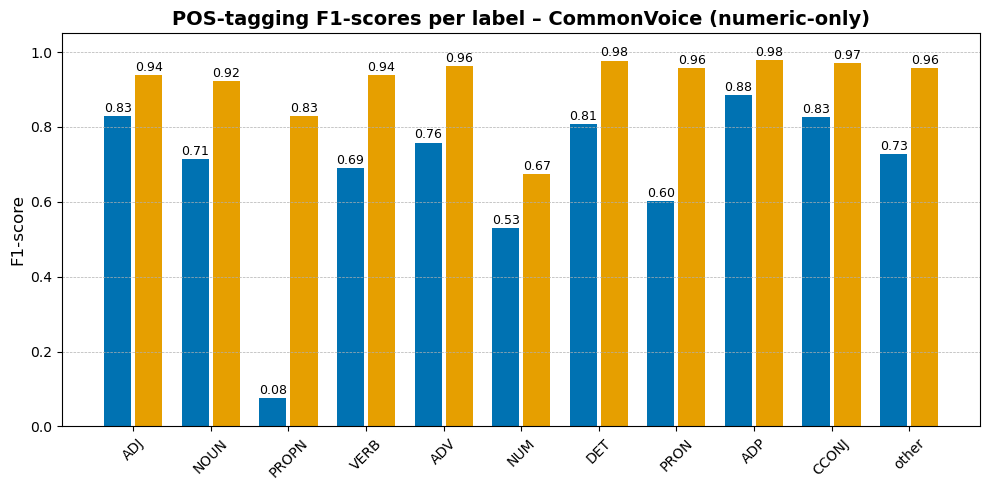

In [4]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 5))

colors = ["#0072B2", "#E69F00"]

labels = df_commonvoice_pos["Label"]
x = range(len(labels))
width = 0.35
gap = 0.05

# Plot beide systemen 
bars1 = ax.bar([i - gap/2 for i in x], df_commonvoice_pos["kNN-MT (sys1)"], width, label="kNN-MT", color=colors[0])
bars2 = ax.bar([i + width + gap/2 for i in x], df_commonvoice_pos["Vanilla (sys2)"], width, label="Vanilla", color=colors[1])


for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f"{height:.2f}", xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', fontsize=9)

# Titel en labels
ax.set_ylabel("F1-score", fontsize=12)
ax.set_title("POS-tagging F1-scores per label – CommonVoice (numeric-only)", fontsize=14, fontweight='bold')
ax.set_xticks([i + width / 2 for i in x])
ax.set_xticklabels(labels, rotation=45, fontsize=10)
ax.set_ylim(0, 1.05)
ax.tick_params(axis='y', labelsize=10)
ax.grid(axis="y", linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.savefig("pos_f1_commonvoice_numeric_only.png", dpi=300, bbox_inches="tight")
plt.show()

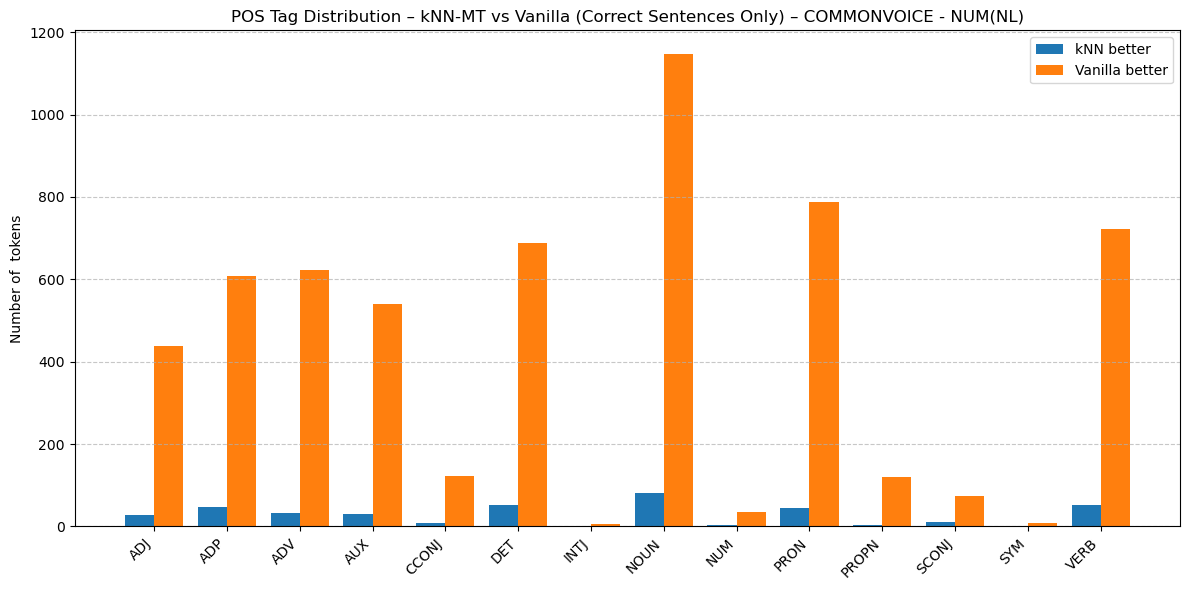

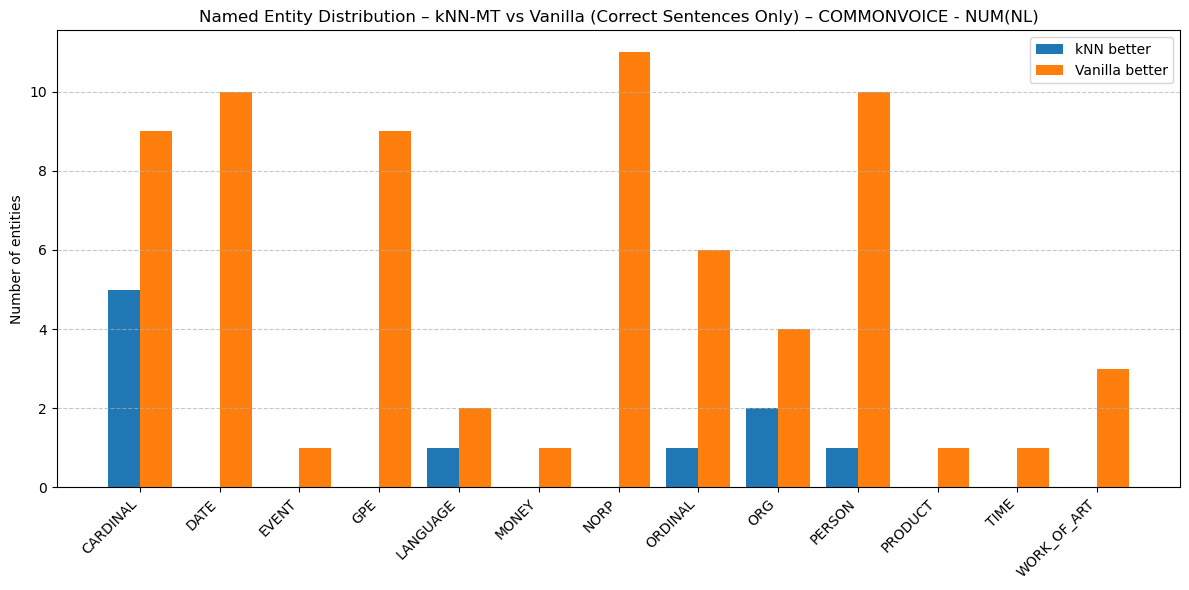

In [5]:
base_path = "/Users/sedatgunay/Desktop/ASR_KNN/dataset data (+outputs)/commonvoice"
lang = "nl"  

# Load data
ref = load_pickle(os.path.join(base_path, "test_ref_texts.pkl"))
knn = load_pickle(os.path.join(base_path, "test_knn_0.1_normalized_texts.pkl"))
van = load_pickle(os.path.join(base_path, "test_van_texts.pkl"))


ref = [normalize_text(line) for line in ref]
van = [normalize_text(line) for line in van]

# Sort better by sentences on systems 
better_knn, better_van = classify_sentences(ref, knn, van)

# POS-tag analysis
pos_knn = extract_pos(better_knn, lang=lang)
pos_van = extract_pos(better_van, lang=lang)
all_pos = sorted(set(pos_knn.keys()).union(pos_van.keys()))

plot_distribution(
    all_pos,
    [pos_knn.get(p, 0) for p in all_pos],
    [pos_van.get(p, 0) for p in all_pos],
    title=f"POS Tag Distribution – kNN-MT vs Vanilla (Correct Sentences Only) – COMMONVOICE - NUM({lang.upper()})",
    ylabel="Number of  tokens"
)

# Entity-analyse
ent_knn = extract_entities(better_knn, lang=lang)
ent_van = extract_entities(better_van, lang=lang)
all_ents = sorted(set(ent_knn.keys()).union(ent_van.keys()))

plot_distribution(
    all_ents,
    [ent_knn.get(e, 0) for e in all_ents],
    [ent_van.get(e, 0) for e in all_ents],
    title=f"Named Entity Distribution – kNN-MT vs Vanilla (Correct Sentences Only) – COMMONVOICE - NUM({lang.upper()})",
    ylabel="Number of entities"
)


In [12]:
# wer analyses
wer_knn = calculate_wer_per_sentence(ref,knn)
wer_van = calculate_wer_per_sentence(ref,van)

# print means 
print("Mean WER (kNN):", wer_summary(ref,knn)["wer"])
print("Mean WER (van):", wer_summary(ref,van)["wer"])


# Vind zinnen waar kNN significant beter was
gain_outliers = get_knn_gain_outliers(ref, knn, van, threshold=0.5)
gain_indices = [entry[0] for entry in gain_outliers]

# gain_outliers

Mean WER (kNN): 0.16665535068235385
Mean WER (van): 0.05540305919553051


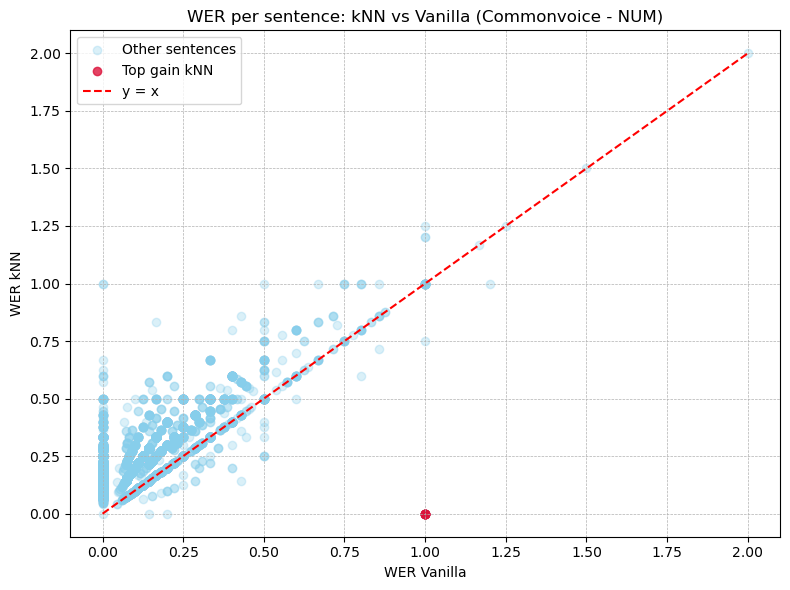

In [14]:
plot_knn_gain_scatter(wer_knn, wer_van,
    gain_indices,
    domain_label="Commonvoice - NUM"
)

In [7]:
import pandas as pd

df_gain = pd.DataFrame(gain_outliers, columns=[
    "Index", "ref", "vanilla", "knn", "wer_vanilla", "wer_knn", "wer_gain_knn"
])

# Sorteer op grootste winst, optioneel
df_gain = df_gain.sort_values(by="wer_gain_knn", ascending=False).reset_index(drop=True)

# Bekijk de eerste rijen
display(df_gain)  


,Index,ref,vanilla,knn,wer_vanilla,wer_knn,wer_gain_knn
0,4285,drie,drie.,drie,1.0,0.0,1.0
1,4286,nee,nee.,nee,1.0,0.0,1.0
2,4308,vier,vier.,vier,1.0,0.0,1.0
3,4352,ja,ja?,ja,1.0,0.0,1.0
4,4364,twee,2,twee,1.0,0.0,1.0
5,4431,firefox,firefox!,firefox,1.0,0.0,1.0


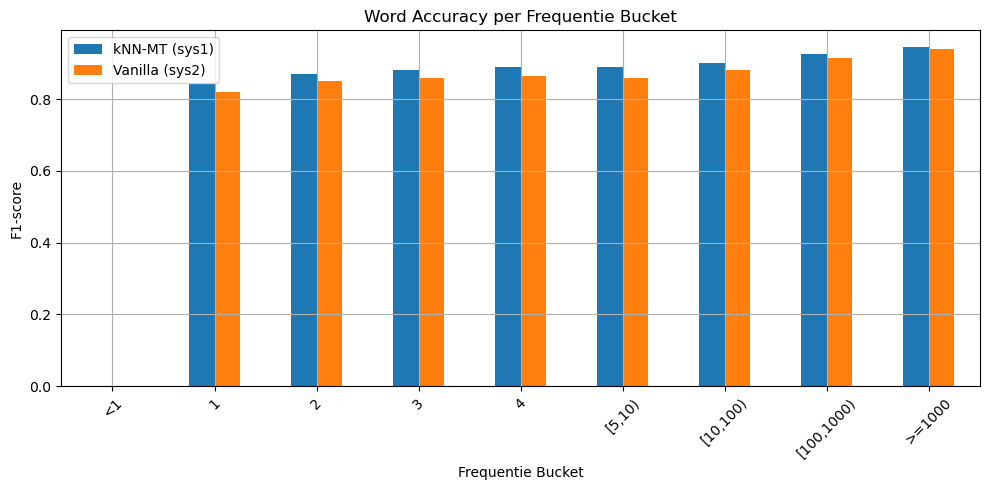

,Frequentie Bucket,kNN-MT (sys1),Vanilla (sys2),Verschil (sys1 - sys2)
0,<1,0.0000,0.0000,0.0000
1,1,0.8414,0.8203,0.0211
2,2,0.8690,0.8505,0.0185
3,3,0.8808,0.8598,0.0210
4,4,0.8889,0.8640,0.0249
5,"[5,10)",0.8885,0.8583,0.0302
6,"[10,100)",0.9020,0.8817,0.0203
7,"[100,1000)",0.9261,0.9157,0.0104
8,>=1000,0.9445,0.9383,0.0062


In [8]:
html_path = "/Users/sedatgunay/Desktop/compare-mt-2/voxpopuli/comparemt_output_freq/index.html"

df_commonvoice_pos_TEST = extract_freq_bucket_scores(html_path)
display(df_commonvoice_pos_TEST)